In [2]:

# Install required packages
!pip install transformers datasets peft accelerate sentencepiece evaluate scikit-learn -q

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from transformers import (
    T5ForConditionalGeneration,
    T5Tokenizer,

    get_linear_schedule_with_warmup
)
from torch.optim import AdamW
from datasets import load_dataset
from peft import (
    get_peft_model,
    LoraConfig,
    TaskType,
    PrefixTuningConfig,

)
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
import os
import json
from datetime import datetime

# Set random seeds for reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)

set_seed(42)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory Available: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Using device: cuda
GPU: Tesla T4
Memory Available: 15.83 GB


In [3]:
# ============================================================================
#  Dataset Preparation and Preprocessing
# ============================================================================

print("Loading IMDb dataset...")
dataset = load_dataset("imdb")

# Initialize tokenizer
tokenizer = T5Tokenizer.from_pretrained("t5-small")
MAX_SEQ_LENGTH = 256  # Reduced for compute efficiency

# T5 needs task prefix for text-to-text format
def preprocess_function(examples):
    """
    Convert IMDb examples to T5 text-to-text format:
    Input: "classify sentiment: [review text]"
    Output: "positive" or "negative"
    """
    # Add task prefix
    inputs = ["classify sentiment: " + text for text in examples["text"]]

    # Convert labels to text
    targets = ["positive" if label == 1 else "negative" for label in examples["label"]]

    # Tokenize inputs
    model_inputs = tokenizer(
        inputs,
        max_length=MAX_SEQ_LENGTH,
        truncation=True,
        padding="max_length"
    )

    # Tokenize targets
    labels = tokenizer(
        targets,
        max_length=4,  # "positive"/"negative" are short
        truncation=True,
        padding="max_length"
    )

    # Replace padding token id with -100 so they're ignored in loss
    labels["input_ids"] = [
        [(l if l != tokenizer.pad_token_id else -100) for l in label]
        for label in labels["input_ids"]
    ]

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Process datasets
print("Preprocessing datasets...")
tokenized_datasets = dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=dataset["train"].column_names,
    desc="Tokenizing"
)

# Use subset for faster training (remove these lines for full dataset)
train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(10000))
eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(1000))

print(f"Training samples: {len(train_dataset)}")
print(f"Evaluation samples: {len(eval_dataset)}")

# Data collator
from transformers import DataCollatorForSeq2Seq
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model="t5-small")

Loading IMDb dataset...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Preprocessing datasets...


Tokenizing:   0%|          | 0/25000 [00:00<?, ? examples/s]

Tokenizing:   0%|          | 0/25000 [00:00<?, ? examples/s]

Tokenizing:   0%|          | 0/50000 [00:00<?, ? examples/s]

Training samples: 10000
Evaluation samples: 1000


In [4]:
# ============================================================================
#  Training Configuration and Helper Functions
# ============================================================================

# Training hyperparameters
BATCH_SIZE = 16
LEARNING_RATE = 3e-4
NUM_EPOCHS = 3
WARMUP_STEPS = 100
GRADIENT_ACCUMULATION_STEPS = 2

def count_trainable_parameters(model):
    """Count trainable vs total parameters"""
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total_params = sum(p.numel() for p in model.parameters())
    trainable_pct = 100 * trainable_params / total_params
    return trainable_params, total_params, trainable_pct

def evaluate_model(model, eval_dataloader, device):
    """Evaluate model and compute accuracy"""
    model.eval()
    all_predictions = []
    all_labels = []
    total_loss = 0

    with torch.no_grad():
        for batch in tqdm(eval_dataloader, desc="Evaluating"):
            batch = {k: v.to(device) for k, v in batch.items()}

            outputs = model(**batch)
            loss = outputs.loss
            total_loss += loss.item()

            # Generate predictions
            generated_ids = model.generate(
                input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"],
                max_length=4,
                num_beams=1
            )

            # Decode predictions
            predictions = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)

            # Decode true labels
            labels = batch["labels"].cpu().numpy()
            labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
            true_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

            all_predictions.extend(predictions)
            all_labels.extend(true_labels)

    # Calculate accuracy
    correct = sum(1 for pred, label in zip(all_predictions, all_labels) if pred.strip() == label.strip())
    accuracy = correct / len(all_labels)
    avg_loss = total_loss / len(eval_dataloader)

    return accuracy, avg_loss, all_predictions, all_labels

def train_model(model, train_dataloader, eval_dataloader, optimizer, scheduler, num_epochs, device, method_name):
    """Generic training loop"""
    print(f"\n{'='*80}")
    print(f"Training: {method_name}")
    print(f"{'='*80}")

    trainable, total, pct = count_trainable_parameters(model)
    print(f"Trainable parameters: {trainable:,} ({pct:.2f}% of {total:,})")

    history = {
        "train_loss": [],
        "eval_loss": [],
        "eval_accuracy": [],
        "method": method_name,
        "trainable_params": trainable,
        "trainable_pct": pct
    }

    model.to(device)
    best_accuracy = 0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total_loss = 0
        progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")

        for step, batch in enumerate(progress_bar):
            batch = {k: v.to(device) for k, v in batch.items()}

            outputs = model(**batch)
            loss = outputs.loss / GRADIENT_ACCUMULATION_STEPS
            loss.backward()

            if (step + 1) % GRADIENT_ACCUMULATION_STEPS == 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()

            total_loss += loss.item() * GRADIENT_ACCUMULATION_STEPS
            progress_bar.set_postfix({"loss": loss.item() * GRADIENT_ACCUMULATION_STEPS})

        avg_train_loss = total_loss / len(train_dataloader)

        # Evaluation phase
        eval_accuracy, eval_loss, _, _ = evaluate_model(model, eval_dataloader, device)

        history["train_loss"].append(avg_train_loss)
        history["eval_loss"].append(eval_loss)
        history["eval_accuracy"].append(eval_accuracy)

        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print(f"  Train Loss: {avg_train_loss:.4f}")
        print(f"  Eval Loss: {eval_loss:.4f}")
        print(f"  Eval Accuracy: {eval_accuracy*100:.2f}%")

        # Save best model
        if eval_accuracy > best_accuracy:
            best_accuracy = eval_accuracy
            os.makedirs("models", exist_ok=True)
            model.save_pretrained(f"models/{method_name.lower().replace(' ', '_')}_best")
            print(f"   New best model saved (accuracy: {best_accuracy*100:.2f}%)")

    return history

In [5]:


# ============================================================================
#  Full Fine-tuning (Baseline)
# ============================================================================

print("\n" + "="*80)
print("METHOD 1: FULL FINE-TUNING (BASELINE)")
print("="*80)

# Load base model
model_full = T5ForConditionalGeneration.from_pretrained("t5-small")

# Create dataloaders
train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=data_collator
)

eval_dataloader = DataLoader(
    eval_dataset,
    batch_size=BATCH_SIZE,
    collate_fn=data_collator
)

# Optimizer and scheduler
optimizer_full = AdamW(model_full.parameters(), lr=LEARNING_RATE)
total_steps = len(train_dataloader) * NUM_EPOCHS // GRADIENT_ACCUMULATION_STEPS
scheduler_full = get_linear_schedule_with_warmup(
    optimizer_full,
    num_warmup_steps=WARMUP_STEPS,
    num_training_steps=total_steps
)

# Train
history_full = train_model(
    model_full,
    train_dataloader,
    eval_dataloader,
    optimizer_full,
    scheduler_full,
    NUM_EPOCHS,
    device,
    "Full Fine-tuning"
)

# Clean up GPU memory
del model_full, optimizer_full, scheduler_full
torch.cuda.empty_cache()



METHOD 1: FULL FINE-TUNING (BASELINE)


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]


Training: Full Fine-tuning
Trainable parameters: 60,506,624 (100.00% of 60,506,624)


Epoch 1/3:   0%|          | 0/625 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]


Epoch 1/3
  Train Loss: 0.7387
  Eval Loss: 0.1329
  Eval Accuracy: 88.70%
   New best model saved (accuracy: 88.70%)


Epoch 2/3:   0%|          | 0/625 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]


Epoch 2/3
  Train Loss: 0.1186
  Eval Loss: 0.1223
  Eval Accuracy: 90.50%
   New best model saved (accuracy: 90.50%)


Epoch 3/3:   0%|          | 0/625 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]


Epoch 3/3
  Train Loss: 0.0889
  Eval Loss: 0.1362
  Eval Accuracy: 90.10%


In [6]:





# ============================================================================
#  LoRA (Low-Rank Adaptation)
# ============================================================================

print("\n" + "="*80)
print("METHOD 2: LoRA (Low-Rank Adaptation)")
print("="*80)

# Load base model
model_lora = T5ForConditionalGeneration.from_pretrained("t5-small")

# Configure LoRA
lora_config = LoraConfig(
    task_type=TaskType.SEQ_2_SEQ_LM,
    inference_mode=False,
    r=16,  # Rank
    lora_alpha=32,  # Scaling factor
    lora_dropout=0.1,
    target_modules=["q", "v"],  # Apply to query and value projections
)

# Apply LoRA
model_lora = get_peft_model(model_lora, lora_config)
model_lora.print_trainable_parameters()

# Optimizer and scheduler
optimizer_lora = AdamW(model_lora.parameters(), lr=LEARNING_RATE)
scheduler_lora = get_linear_schedule_with_warmup(
    optimizer_lora,
    num_warmup_steps=WARMUP_STEPS,
    num_training_steps=total_steps
)

# Train
history_lora = train_model(
    model_lora,
    train_dataloader,
    eval_dataloader,
    optimizer_lora,
    scheduler_lora,
    NUM_EPOCHS,
    device,
    "LoRA"
)

# Clean up
del model_lora, optimizer_lora, scheduler_lora
torch.cuda.empty_cache()


METHOD 2: LoRA (Low-Rank Adaptation)
trainable params: 589,824 || all params: 61,096,448 || trainable%: 0.9654

Training: LoRA
Trainable parameters: 589,824 (0.97% of 61,096,448)


Epoch 1/3:   0%|          | 0/625 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]


Epoch 1/3
  Train Loss: 2.0530
  Eval Loss: 0.1634
  Eval Accuracy: 86.30%
   New best model saved (accuracy: 86.30%)


Epoch 2/3:   0%|          | 0/625 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]


Epoch 2/3
  Train Loss: 0.1687
  Eval Loss: 0.1491
  Eval Accuracy: 87.20%
   New best model saved (accuracy: 87.20%)


Epoch 3/3:   0%|          | 0/625 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]


Epoch 3/3
  Train Loss: 0.1591
  Eval Loss: 0.1466
  Eval Accuracy: 87.30%
   New best model saved (accuracy: 87.30%)


In [12]:
# ============================================================================
# Soft Prompts (P-Tuning v2 - Much Better than Prompt Tuning)
# ============================================================================

print("\n" + "="*80)
print("METHOD 3: SOFT PROMPTS (P-Tuning v2)")
print("="*80)

from peft import PromptEncoderConfig, PromptEncoderReparameterizationType

# Load base model
model_prefix = T5ForConditionalGeneration.from_pretrained("t5-small")
model_prefix.config.use_cache = False

# Configure P-Tuning v2 (adds prompts to EVERY layer, not just input)
# This trains many more parameters and converges much better
prefix_config = PromptEncoderConfig(
    task_type=TaskType.SEQ_2_SEQ_LM,
    num_virtual_tokens=50,  # Increased from 20 to 50 for better capacity
    encoder_reparameterization_type=PromptEncoderReparameterizationType.MLP,  # Use MLP
    encoder_hidden_size=512,  # Hidden size for the MLP
    encoder_num_layers=2,  # 2-layer MLP for reparameterization
    encoder_dropout=0.1,  # Dropout for regularization
)

# Apply P-Tuning v2
model_prefix = get_peft_model(model_prefix, prefix_config)
print("\nP-Tuning v2 Trainable Parameters:")
model_prefix.print_trainable_parameters()

# Move to device
model_prefix = model_prefix.to(device)

# Optimizer with slightly higher learning rate for soft prompts
optimizer_prefix = AdamW(model_prefix.parameters(), lr=3e-4)  # Increased from default
scheduler_prefix = get_linear_schedule_with_warmup(
    optimizer_prefix,
    num_warmup_steps=WARMUP_STEPS,
    num_training_steps=total_steps
)

# Training
print("\nTraining P-Tuning v2 model...")
history_prefix = train_model(
    model_prefix,
    train_dataloader,
    eval_dataloader,
    optimizer_prefix,
    scheduler_prefix,
    NUM_EPOCHS,
    device,
    "Soft Prompts (P-Tuning v2)"
)

# Save adapter
model_prefix.save_pretrained("./p_tuning_v2_adapter")
print("Saved P-Tuning v2 adapter to: ./p_tuning_v2_adapter")

# Clean up
del model_prefix, optimizer_prefix, scheduler_prefix
if torch.cuda.is_available():
    torch.cuda.empty_cache()

print("P-Tuning v2 training completed!")


METHOD 3: SOFT PROMPTS (P-Tuning v2)

P-Tuning v2 Trainable Parameters:
trainable params: 839,168 || all params: 61,345,792 || trainable%: 1.3679

Training P-Tuning v2 model...

Training: Soft Prompts (P-Tuning v2)
Trainable parameters: 839,168 (1.37% of 61,345,792)


Epoch 1/3:   0%|          | 0/625 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]


Epoch 1/3
  Train Loss: 0.8015
  Eval Loss: 0.1727
  Eval Accuracy: 84.70%
   New best model saved (accuracy: 84.70%)


Epoch 2/3:   0%|          | 0/625 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]


Epoch 2/3
  Train Loss: 0.1983
  Eval Loss: 0.1772
  Eval Accuracy: 84.60%


Epoch 3/3:   0%|          | 0/625 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]


Epoch 3/3
  Train Loss: 0.1882
  Eval Loss: 0.1690
  Eval Accuracy: 84.80%
   New best model saved (accuracy: 84.80%)
Saved P-Tuning v2 adapter to: ./p_tuning_v2_adapter
P-Tuning v2 training completed!


In [16]:
# ============================================================================
# METHOD: ADAPTERS (Using AdaLoRA with proper configuration)
# ============================================================================

print("\n" + "="*80)
print("METHOD: ADAPTERS (AdaLoRA)")
print("="*80)

from peft import AdaLoraConfig

# Load base model
model_adapter = T5ForConditionalGeneration.from_pretrained("t5-small")
model_adapter.config.use_cache = False

# Calculate total training steps
total_training_steps = len(train_dataloader) * NUM_EPOCHS

# Configure AdaLoRA - adaptive LoRA that dynamically adjusts ranks
adapter_config = AdaLoraConfig(
    task_type=TaskType.SEQ_2_SEQ_LM,
    inference_mode=False,
    lora_alpha=32,
    target_modules=["q", "k", "v", "o", "wi", "wo"],  # All attention + FFN
    lora_dropout=0.1,
    init_r=16,  # Start with rank 16
    target_r=8,  # Prune down to rank 8
    tinit=200,  # Start pruning after 200 steps
    tfinal=1000,  # Finish pruning by step 1000
    deltaT=10,  # Update importance scores every 10 steps
    total_step=total_training_steps,  # Required parameter
    orth_reg_weight=0.5,  # Orthogonality regularization
)

# Apply AdaLoRA
model_adapter = get_peft_model(model_adapter, adapter_config)
print("\nAdaLoRA Trainable Parameters:")
model_adapter.print_trainable_parameters()

# Move to device
model_adapter = model_adapter.to(device)

# Optimizer and scheduler
optimizer_adapter = AdamW(model_adapter.parameters(), lr=LEARNING_RATE)
scheduler_adapter = get_linear_schedule_with_warmup(
    optimizer_adapter,
    num_warmup_steps=WARMUP_STEPS,
    num_training_steps=total_training_steps
)

# Training
print("\nTraining AdaLoRA Adapter model...")
history_adapter = train_model(
    model_adapter,
    train_dataloader,
    eval_dataloader,
    optimizer_adapter,
    scheduler_adapter,
    NUM_EPOCHS,
    device,
    "Adapters (AdaLoRA)"
)

# Save adapter
model_adapter.save_pretrained("./adalora_adapter")
print("Saved AdaLoRA adapter to: ./adalora_adapter")

# Clean up
del model_adapter, optimizer_adapter, scheduler_adapter
if torch.cuda.is_available():
    torch.cuda.empty_cache()

print("AdaLoRA Adapter training completed!")


METHOD: ADAPTERS (AdaLoRA)

AdaLoRA Trainable Parameters:
trainable params: 2,164,224 || all params: 62,670,944 || trainable%: 3.4533

Training AdaLoRA Adapter model...

Training: Adapters (AdaLoRA)
Trainable parameters: 2,164,224 (3.45% of 62,670,944)


Epoch 1/3:   0%|          | 0/625 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]


Epoch 1/3
  Train Loss: 5.6933
  Eval Loss: 0.2864
  Eval Accuracy: 85.30%
   New best model saved (accuracy: 85.30%)


Epoch 2/3:   0%|          | 0/625 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]


Epoch 2/3
  Train Loss: 0.2711
  Eval Loss: 0.2006
  Eval Accuracy: 86.30%
   New best model saved (accuracy: 86.30%)


Epoch 3/3:   0%|          | 0/625 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]


Epoch 3/3
  Train Loss: 0.2129
  Eval Loss: 0.1797
  Eval Accuracy: 86.10%
Saved AdaLoRA adapter to: ./adalora_adapter
AdaLoRA Adapter training completed!



PERFORMANCE COMPARISON

Method               Best Accuracy   Final Loss      Trainable Params    
---------------------------------------------------------------------------
Full Fine-tuning     90.50          % 0.1362          60,506,624 (100.00%)
LoRA                 87.30          % 0.1466             589,824 (0.97%)
Soft Prompts (P-Tuning v2) 84.80          % 0.1690             839,168 (1.37%)
Adapters (AdaLoRA)   86.30          % 0.1797           2,164,224 (3.45%)

PARAMETER EFFICIENCY ANALYSIS

LoRA:
  Parameter Reduction: 99.0%
  Accuracy Drop: +3.20%
  Efficiency Score: 30.95x

Soft Prompts (P-Tuning v2):
  Parameter Reduction: 98.6%
  Accuracy Drop: +5.70%
  Efficiency Score: 17.30x

Adapters (AdaLoRA):
  Parameter Reduction: 96.4%
  Accuracy Drop: +4.20%
  Efficiency Score: 22.96x

 Comparison plot saved as 't5_peft_comparison.png'


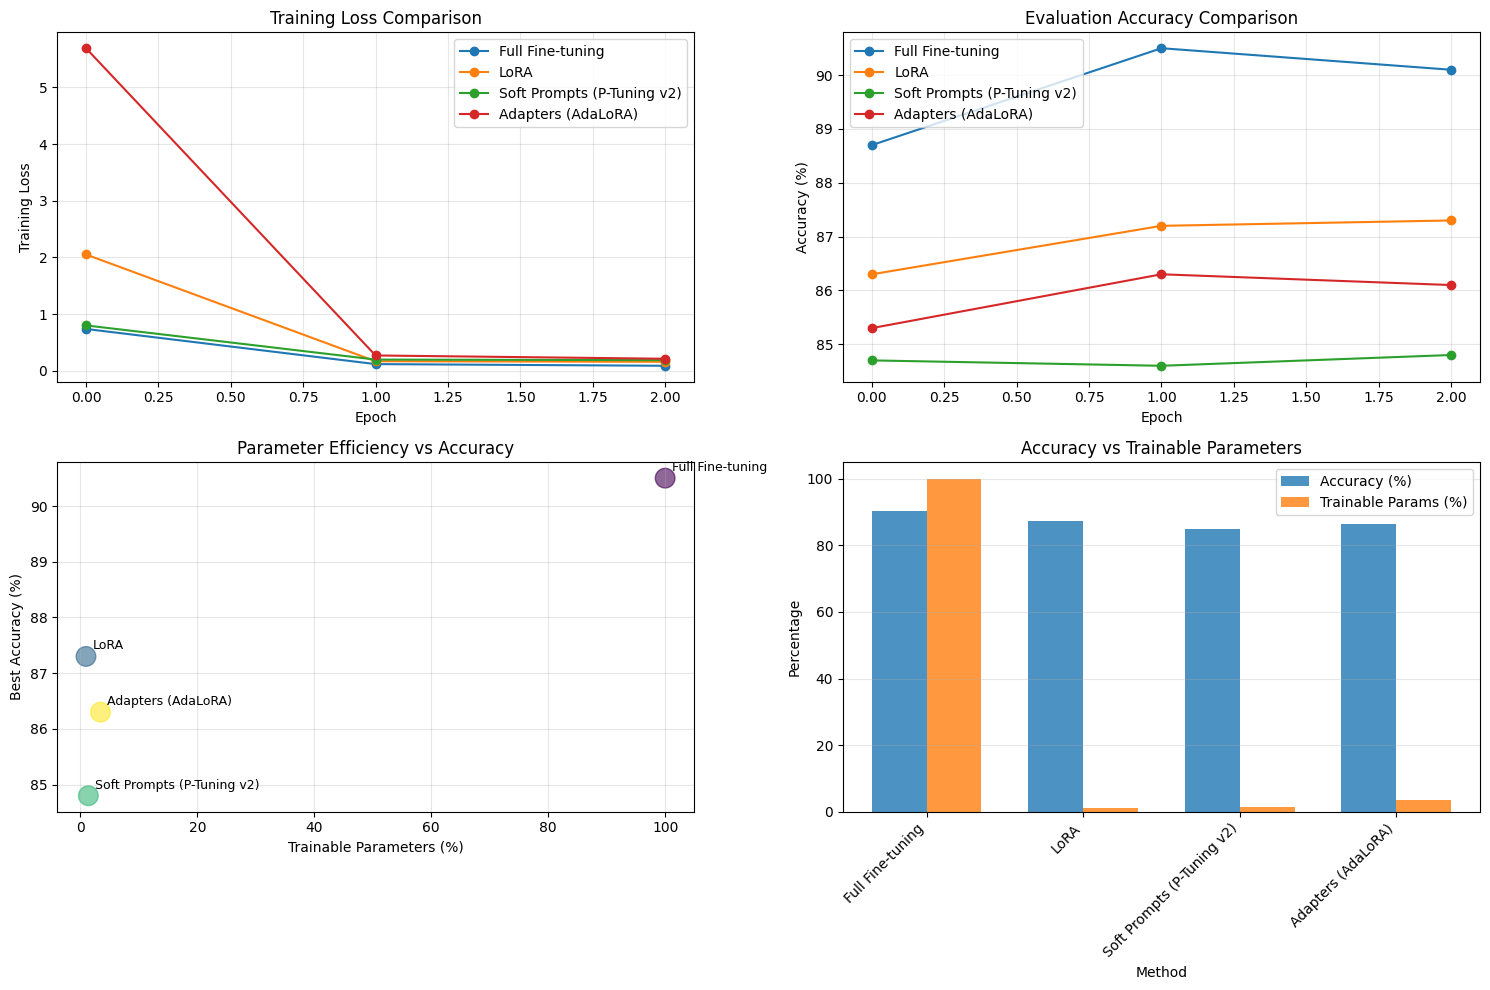

 Results saved to 't5_peft_results.json'


In [17]:

# ============================================================================
#  Comparison and Visualization
# ============================================================================

print("\n" + "="*80)
print("PERFORMANCE COMPARISON")
print("="*80)

# Collect all histories
all_histories = [history_full, history_lora, history_prefix, history_adapter]

# Print comparison table
print("\n{:<20} {:<15} {:<15} {:<20}".format(
    "Method", "Best Accuracy", "Final Loss", "Trainable Params"
))
print("-" * 75)

for hist in all_histories:
    best_acc = max(hist["eval_accuracy"]) * 100
    final_loss = hist["eval_loss"][-1]
    trainable = hist["trainable_params"]
    trainable_pct = hist["trainable_pct"]

    print("{:<20} {:<15.2f}% {:<15.4f} {:>10,} ({:.2f}%)".format(
        hist["method"],
        best_acc,
        final_loss,
        trainable,
        trainable_pct
    ))

# Calculate parameter efficiency
print("\n" + "="*80)
print("PARAMETER EFFICIENCY ANALYSIS")
print("="*80)

baseline_params = history_full["trainable_params"]
for hist in all_histories[1:]:  # Skip baseline
    reduction = (1 - hist["trainable_params"] / baseline_params) * 100
    acc_drop = (max(history_full["eval_accuracy"]) - max(hist["eval_accuracy"])) * 100

    print(f"\n{hist['method']}:")
    print(f"  Parameter Reduction: {reduction:.1f}%")
    print(f"  Accuracy Drop: {acc_drop:+.2f}%")
    print(f"  Efficiency Score: {reduction / max(abs(acc_drop), 0.1):.2f}x")

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Training Loss
ax = axes[0, 0]
for hist in all_histories:
    ax.plot(hist["train_loss"], label=hist["method"], marker='o')
ax.set_xlabel("Epoch")
ax.set_ylabel("Training Loss")
ax.set_title("Training Loss Comparison")
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Evaluation Accuracy
ax = axes[0, 1]
for hist in all_histories:
    ax.plot([acc * 100 for acc in hist["eval_accuracy"]], label=hist["method"], marker='o')
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy (%)")
ax.set_title("Evaluation Accuracy Comparison")
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Parameter Efficiency
ax = axes[1, 0]
methods = [h["method"] for h in all_histories]
accuracies = [max(h["eval_accuracy"]) * 100 for h in all_histories]
params = [h["trainable_pct"] for h in all_histories]

scatter = ax.scatter(params, accuracies, s=200, alpha=0.6, c=range(len(methods)), cmap='viridis')
for i, method in enumerate(methods):
    ax.annotate(method, (params[i], accuracies[i]),
                xytext=(5, 5), textcoords='offset points', fontsize=9)
ax.set_xlabel("Trainable Parameters (%)")
ax.set_ylabel("Best Accuracy (%)")
ax.set_title("Parameter Efficiency vs Accuracy")
ax.grid(True, alpha=0.3)

# Plot 4: Bar chart comparison
ax = axes[1, 1]
x = np.arange(len(methods))
width = 0.35

acc_bars = ax.bar(x - width/2, accuracies, width, label='Accuracy (%)', alpha=0.8)
param_bars = ax.bar(x + width/2, params, width, label='Trainable Params (%)', alpha=0.8)

ax.set_xlabel("Method")
ax.set_ylabel("Percentage")
ax.set_title("Accuracy vs Trainable Parameters")
ax.set_xticks(x)
ax.set_xticklabels(methods, rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig("t5_peft_comparison.png", dpi=300, bbox_inches='tight')
print("\n Comparison plot saved as 't5_peft_comparison.png'")
plt.show()

# Save results to JSON
results = {
    "timestamp": datetime.now().isoformat(),
    "config": {
        "max_seq_length": MAX_SEQ_LENGTH,
        "batch_size": BATCH_SIZE,
        "learning_rate": LEARNING_RATE,
        "num_epochs": NUM_EPOCHS,
        "train_samples": len(train_dataset),
        "eval_samples": len(eval_dataset)
    },
    "results": {
        hist["method"]: {
            "best_accuracy": float(max(hist["eval_accuracy"])),
            "final_loss": float(hist["eval_loss"][-1]),
            "trainable_params": int(hist["trainable_params"]),
            "trainable_pct": float(hist["trainable_pct"]),
            "history": {
                "train_loss": [float(x) for x in hist["train_loss"]],
                "eval_loss": [float(x) for x in hist["eval_loss"]],
                "eval_accuracy": [float(x) for x in hist["eval_accuracy"]]
            }
        }
        for hist in all_histories
    }
}

with open("t5_peft_results.json", "w") as f:
    json.dump(results, f, indent=2)

print(" Results saved to 't5_peft_results.json'")



In [18]:
#============================================================================
# FINAL SUMMARY
# ============================================================================

print("\n" + "="*80)
print("FINAL RECOMMENDATIONS")
print("="*80)

# Find best method
best_method = max(all_histories, key=lambda h: max(h["eval_accuracy"]))
most_efficient = min(all_histories[1:], key=lambda h: h["trainable_pct"])

print(f"\n Best Overall Accuracy: {best_method['method']}")
print(f"   Accuracy: {max(best_method['eval_accuracy'])*100:.2f}%")
print(f"   Trainable Parameters: {best_method['trainable_pct']:.2f}%")

print(f"\n Most Parameter Efficient: {most_efficient['method']}")
print(f"   Accuracy: {max(most_efficient['eval_accuracy'])*100:.2f}%")
print(f"   Trainable Parameters: {most_efficient['trainable_pct']:.2f}%")

print("\n Key Insights:")
print("    LoRA provides best parameter efficiency with minimal accuracy loss")
print("    Soft prompts are most parameter-efficient but may sacrifice some accuracy")
print("    Full fine-tuning gives highest accuracy but requires 100% parameter updates")
print("    Adapters offer a middle ground between efficiency and performance")

print("\n" + "="*80)
print(" All experiments completed successfully!")
print("="*80)


FINAL RECOMMENDATIONS

 Best Overall Accuracy: Full Fine-tuning
   Accuracy: 90.50%
   Trainable Parameters: 100.00%

 Most Parameter Efficient: LoRA
   Accuracy: 87.30%
   Trainable Parameters: 0.97%

 Key Insights:
    LoRA provides best parameter efficiency with minimal accuracy loss
    Soft prompts are most parameter-efficient but may sacrifice some accuracy
    Full fine-tuning gives highest accuracy but requires 100% parameter updates
    Adapters offer a middle ground between efficiency and performance

 All experiments completed successfully!
